## Summary:
- I searched through several corpora to see what kinds of transcript data and demographic details of the speakers (age, sex, etc) were available, for my master's thesis.
- The best corpus I found is the CRECIL corpus, based on a Chinese sitcom from the 90s called "I love my family".
- One issue at first with the dialogue data in the Final_Data/ directory was that only labels and the relations present within a given dialogue were provided, but you are not able to see who is addressing who for each turn. This makes it complicated to work with dialogues containing many characters.
- Fortunately, even in this directory, there are also a good number of dialogues with only 2 speakers, that also covers a wide variety of relations.
- It would later turn out that the dialogue data in the Original_Data/ directory, combined with the annotated relations, provides adequate information to gather utterances between individual characters alongside their relation, and thereby giving a way to study formality features of the spoken utterances.

In [4]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib import font_manager
import re
from pathlib import Path
from tqdm import tqdm
import json
import pickle
import numpy as np
import collections

**CRECIL corpus**
- [paper](http://www.lrec-conf.org/proceedings/lrec2022/pdf/2022.lrec-1.250.pdf)
- [Github](https://github.com/bistu-nlp-lab/CRECIL)

#### Key notes from paper
- 140 entities annotated with relations in total. I will double check this. 
- When relations are first identified, the time stamps are recorded. I need to find where those are kept. 
- The 'alternate_name' relation is used for when there exists more than one name used for a given character. I will need to create my own dictionary mapping. 
- They have a BERT model to use as a baseline relation extractor, which I might try to run. 

In [2]:
#Get quick percentage of the T/V 你/您 in the training corpus of Final_Data/
with open('../CRECIL/Final_Data/train.json','r') as infile:
    train_df = json.loads(infile.read())
    
ni_count = 0
nin_count = 0

for i in tqdm(range(0,len(train_df))):

    raw_list = train_df[i][0]
    for raw in raw_list:

        ni_count += len(re.findall('你',raw))
        nin_count += len(re.findall('您',raw))
        
print(f'{round(100*(nin_count/(nin_count+ni_count)),2)}% of "you"s are 您')
print(f'{nin_count} instances out of {nin_count+ni_count}')

100%|██████████████████████████████████████| 482/482 [00:00<00:00, 27476.72it/s]

28.39% of "you"s are 您
2800 instances out of 9863


This is a pretty good distribution compared to other corpora I've explored. In many natural speech corpora (CallFriend, etc), the percent that is 您 is <1%.

Something just dawning on me now: in the transcript with multiple people, it's not super clear who each line is being directed _at_. This is a problem, because that's the signal that I'm hoping will tell me how formality is being used. However it seems like this is equality important for relation extraction, so I can learn how the baseline/other approaches resolve this. 

On the other hand, there might be dialogues with only 2 speakers, in which case I can assume they are talking to each other. 

Text(0.5, 0.98, 'No. of dialogs by no. of speakers in dialog')

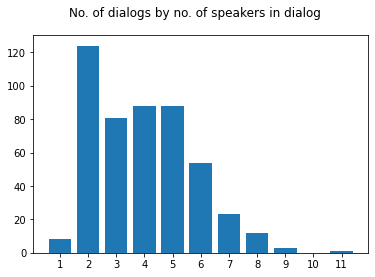

In [3]:
#Find number of speakers per dialogue, and visualize
dialog_chars = Counter()
len_dict = Counter()

for i in range(0,len(train_df)):
    char_set = set()
    for j in range(0,len(train_df[i][0])):
        char_set.add(re.findall('.*(?<=:)',train_df[i][0][j])[0])
    dialog_chars[i] = len(char_set)
    
    if len(char_set) not in len_dict:
        len_dict[len(char_set)] = 0
    len_dict[len(char_set)] += 1

#No. of dialogs by no. of speakers in dialog
plot = plt.bar(len_dict.keys(),len_dict.values())
plt.xticks(range(1, len(len_dict.values())+2))
plt.suptitle("No. of dialogs by no. of speakers in dialog")

Text(0.5, 0.98, 'Relations annotated in 2-person dialogs')

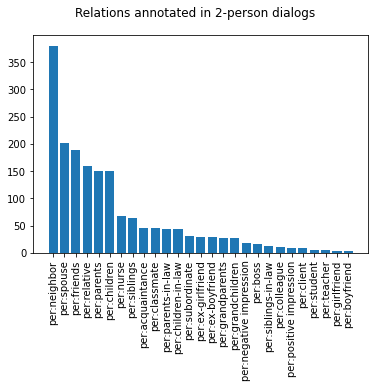

In [4]:
#Display the main relations present in 2-person dialogs
pair_dialog_indices = [i for i in list(dialog_chars.keys()) if dialog_chars[i]==2]

all_roles = dict()
for dg in pair_dialog_indices:
    for i in range(0,len(train_df[dg][1])):
        if train_df[dg][1][i]['r'][0] not in all_roles:
            all_roles[train_df[dg][1][i]['r'][0]] = 0
        all_roles[train_df[dg][1][i]['r'][0]] += 1     
        
all_roles_list = sorted(all_roles.items(), key=lambda x:x[1],reverse=True)

ignore_relations = ['unanswerable','per:alternate_name']
all_roles_keys = [item[0] for item in all_roles_list if item[0] not in ignore_relations]
all_roles_values = [item[1] for item in all_roles_list if item[0] not in ignore_relations]

plt.xticks(rotation=90)
plt.bar(all_roles_keys,all_roles_values)

plt.suptitle("Relations annotated in 2-person dialogs")

**Notes**:
- There is some double-counting from the inverse of the same relationship being recorded (e.g. per:parents and per:children have same counts)
- There are a few strange relations such as 'per:negative impression' which I will need to understand better
- Overall though, a good distribution of relations

In [8]:
#Show a sample dialogue
train_df[pair_dialog_indices[0]][0]

['S 1: 小张啊，你得有现代意识，挣了钱老存着，怎么也是个死的，资金一定要流动，你看，这回呀，我跟爷爷合伙做了笔生意，嗯，弄好了呢，能挣大钱……',
 'S 2: 小凡姐，这样的好事儿，你总忘了叫我',
 'S 1: 现在也不晚呐，我给您来了内部调济，我来了十股，你来多少？',
 'S 2: 那，我也跟你，入一股，给，两块',
 'S 1: 这就对了嘛，我给你打一条去']

In [10]:
#Show another sample dialogue
train_df[pair_dialog_indices[1]][0][0:5]

['S 1: 这位同志，这位同志，您都跟了我一道了，您怎么还跟家里来了？你赶紧出去，您不出去我报警了我！……',
 'S 2: 您这儿是生活之友吧，杨柳北里十八号？',
 'S 1: 他们把广告登错了，我们正准备打电话更正呢。',
 'S 2: 您就甭谦虚了。我一看见您，我就知道，您是大夫……',
 'S 1: 我不是，得，那我就甭谦虚了，我就冒充一回大夫吧，您坐，您说吧，您哪不好啊？']

In [9]:
#Answer the question: what is the T/V 你/您 breakdown of dialogues between only 2 characters?
ni_count = 0
nin_count = 0

for i in range(0,len(pair_dialog_indices)):

    raw_list = train_df[pair_dialog_indices[i]][0]
    for raw in raw_list:

        ni_count += len(re.findall('你',raw))
        nin_count += len(re.findall('您',raw))
        
print(f'{round(100*(nin_count/(nin_count+ni_count)),2)}% of "you"s are 您')
print(f'{nin_count} instances out of {nin_count+ni_count}')

25.47% of "you"s are 您
595 instances out of 2336


Note the similar 你/您 split as for the overall corpus

In [10]:
#Show another sample dialogue from this subset
pair_dialog_df = [train_df[i] for i in pair_dialog_indices]
pair_dialog_df[8][0][0:7]

['S 1: 喽？这是干什么呀？',
 'S 2: 志新放出来好几天了，我们想请胡伯伯跟胡伯母啊，过来吃顿饭',
 'S 1: 请他们干什么？',
 'S 2: 嗯？',
 'S 1: 志新放出来，是海南方面把问题搞清楚了嘛，他们总经理开车撞的人，他们当然要放啦，跟他胡学范有什么关系',
 'S 2: 爸，您怎么过河拆桥啊？',
 'S 1: 别人的桥，可以不拆，他的桥我还非拆不可，这个事件办成了，应该感谢政府感谢党嘛，用的着感谢胡学范嘛，都是你们，非得让我去求他']

In [10]:
#Have a look at the annotations provided for a dialogue
pair_dialog_df[8][1][0:7]

[{'x': 'S 1', 'y': 'S 2', 'r': ['per:parents-in-law'], 'rid': [15]},
 {'x': 'S 1', 'y': '志新', 'r': ['per:parents'], 'rid': [2]},
 {'x': 'S 1',
  'y': '胡伯伯',
  'r': ['per:neighbor', 'per:friends', 'per:colleague'],
  'rid': [13, 11, 5]},
 {'x': 'S 1', 'y': '胡伯母', 'r': ['per:friends'], 'rid': [11]},
 {'x': 'S 1',
  'y': '胡学范',
  'r': ['per:neighbor', 'per:friends', 'per:colleague'],
  'rid': [13, 11, 5]},
 {'x': 'S 1',
  'y': '老胡',
  'r': ['per:neighbor', 'per:friends', 'per:colleague'],
  'rid': [13, 11, 5]},
 {'x': 'S 2', 'y': 'S 1', 'r': ['per:children-in-law'], 'rid': [16]}]

Here, and in a few other examples, it looks like the relation annotation is in reverse order. From the dialogue, S2 says, "爸..." to S1, whereas the relation annotated is <br/>
<br/>
'x': 'S 1', 'y': 'S 2', 'r': ['per:parents-in-law'] <br/>
<br/>
These examples, as well as the diagram in [this image](https://github.com/bistu-nlp-lab/CRECIL), leads me to believe that relations are annotated as "x is the per:_relation_ of y", or "S1 is the _parents-in-law_ of S2" <br/>
<br/>
With this, I can make a dataframe with variables= _text_, _speaker-addressee-relation_

In [11]:
#Make a pandas dataframe from the 2-person dialogue data
pair_df = []

for item in pair_dialog_df:
    

    S1_title = ''
    S2_title = ''

    for rel in item[1]:

        if rel['x']=='S 1' and rel['y']=='S 2':

            S1_title = re.findall('(?<=per:).*',rel['r'][0])
            if len(S1_title)>0: 
                S1_title=S1_title[0]

        if rel['y']=='S 1' and rel['x']=='S 2':

            S2_title = re.findall('(?<=per:).*',rel['r'][0])
            if len(S2_title)>0: 
                S2_title=S2_title[0]

        if len(S1_title)>0 and len(S2_title)>0:

            S1_relation = S1_title+":"+S2_title
            S2_relation = S2_title+":"+S1_title

            for line in item[0]:
                party = re.findall('^S\s[1-2]',line)
                if len(party)>0: 
                    party=party[0]

                    if party =='S 1':
                        pair_df.append((line,S1_relation))
                    elif party=='S 2':
                        pair_df.append((line,S2_relation))

pair_df = pd.DataFrame(list(pair_df),columns=['text','relation'])

In [9]:
#Show the most common relations annotated
Counter(pair_df.relation).most_common()

[('spouse:spouse', 9637),
 ('friends:friends', 5821),
 ('children-in-law:parents-in-law', 5705),
 ('parents-in-law:children-in-law', 5576),
 ('neighbor:neighbor', 4026),
 ('relative:relative', 2684),
 ('classmate:classmate', 2552),
 ('children:parents', 1178),
 ('parents:children', 1158),
 ('subordinate:nurse', 765),
 ('nurse:subordinate', 741),
 ('grandparents:grandchildren', 546),
 ('grandchildren:grandparents', 532),
 ('acquaintance:acquaintance', 504),
 ('siblings:siblings', 490)]

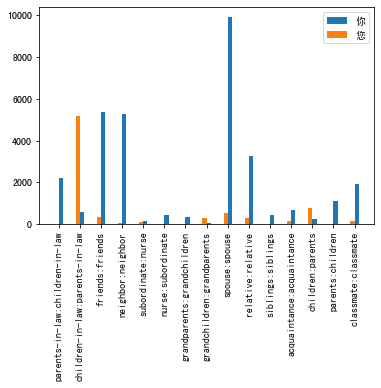

In [12]:
#Turn relations into a dictionary, separable by T/V pronoun used and graph
rel_dict = dict()
for rel in list(pair_df.relation.unique()):
    rel_dict[rel]=dict()
    rel_dict[rel]['你']=0
    rel_dict[rel]['您']=0
    
for i in range(0,len(pair_df)):
        
    rel_dict[pair_df.relation.iloc[i]]['你'] += len(re.findall('你',pair_df.text.iloc[i]))
    rel_dict[pair_df.relation.iloc[i]]['您'] += len(re.findall('您',pair_df.text.iloc[i]))
    
#reverse the order of the nested keys in rel_dict
rel_dict_2 = dict()
rel_dict_2['你'] = dict()
rel_dict_2['您'] = dict()

for item in rel_dict:
    rel_dict_2['你'][item] = rel_dict[item]['你']
    rel_dict_2['您'][item] = rel_dict[item]['您']
    
from matplotlib import font_manager


plt.rcParams['font.sans-serif'] = ['SimHei']


fig, ax = plt.subplots()

ax.bar(rel_dict_2['你'].keys(), rel_dict_2['你'].values(), width=0.2, align='edge', label='你')
ax.bar(rel_dict_2['您'].keys(), rel_dict_2['您'].values(), width=-0.2, align='edge', label='您')


ax.legend()
plt.xticks(rotation=90)


fig.show()

In [13]:
#Present data as an observation table
rel_df = pd.DataFrame(rel_dict_2)
rel_df

你     您
parents-in-law:children-in-law  2218     4
children-in-law:parents-in-law   588  5159
friends:friends                 5387   353
neighbor:neighbor               5292    79
subordinate:nurse                172   100
nurse:subordinate                422     0
grandparents:grandchildren       320     0
grandchildren:grandparents        38   275
spouse:spouse                   9910   512
relative:relative               3261   283
siblings:siblings                441     0
acquaintance:acquaintance        702   135
children:parents                 246   772
parents:children                1105     2
classmate:classmate             1924   140

I can use the Pearson’s Chi-Square test to test independence between the variables, in this case represented by the direction of speaker-to-addressee. This is analagous to the scenario tested [here](https://www.geeksforgeeks.org/python-pearsons-chi-square-test/)

In [14]:
#Perform a simple pearson's chi-square test to see if data come from same distribution
from scipy.stats import chi2_contingency

# defining the table
stat, p, dof, expected = chi2_contingency(rel_df)
 
# interpret p-value
alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (H0 holds true)')

p value is 0.0
Dependent (reject H0)


##### Subtask
Get relationship mappings of all characters in the show <br/>
-> found in ../CRECIL/Orginal_data/relation/relation.txt

In [5]:
#Find relations annotated between characters
with open('../CRECIL/Orginal_data/relation/relation.txt','r') as infile:
    relations_txt = infile.read()
relations_txt.split('\n')[0:5]

["('小晴', '表妹')\t['per:alternate_name']",
 "('大壮', '秀芳')\t['per:children']",
 "('秀芳', '大壮')\t['per:parents']",
 "('许警察', '于大妈')\t['per:acquaintance']",
 "('小许', '许警察')\t['per:alternate_name']"]

In [7]:
#Put into pandas format. Remember that the relation is A is stated 
#relation (e.g. parent) of B
A = []
B = []
relations = []
pattern = re.compile("'.*?'")
for line in relations_txt.split('\n'):
    if len(line)>0:
        A.append(pattern.findall(line)[0].replace("'",""))
        B.append(pattern.findall(line)[1].replace("'",""))
        relations.append(pattern.findall(line)[2].replace("'",""))
all_relations = pd.DataFrame(list(zip(A,B,relations)),columns = ['A','B','relation'])


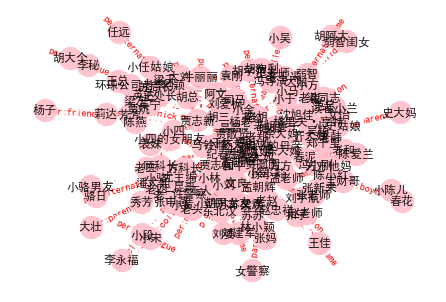

In [8]:
#Graph the characters and relations in a network
import networkx as nx
from matplotlib import font_manager

G = nx.Graph()
G.add_nodes_from([item for item in set(all_relations.A)])
G.add_edges_from([(all_relations.A.iloc[i],all_relations.B.iloc[i]) for i in range(0,len(all_relations))])

edge_labs = dict()
for i in range(0,len(all_relations)):
    edge_labs[(all_relations.A.iloc[i],all_relations.B.iloc[i])] = all_relations.relation.iloc[i] 
    


plt.rcParams['font.sans-serif'] = ['SimHei']

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= edge_labs,
    font_color='red'
)
plt.axis('off')
plt.show()

Far too many, maybe limit to the top 10 -> Actually 8 looks better

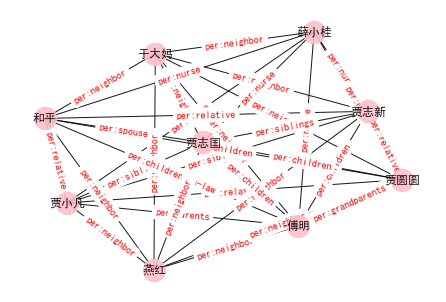

In [9]:
#Repeat the above graph, but for the most common characters only
list_a = [item[0] for item in Counter(all_relations.A).most_common(8)]
list_b = [item[0] for item in Counter(all_relations.B).most_common(8)]
some_relations = all_relations[all_relations.A.isin(list_a)&all_relations.B.isin(list_b)] 

G = nx.Graph()
G.add_nodes_from([item for item in set(some_relations.A)])
G.add_edges_from([(some_relations.A.iloc[i],some_relations.B.iloc[i]) for i in range(0,len(some_relations))])
edge_labs = dict()
for i in range(0,len(some_relations)):
    edge_labs[(some_relations.A.iloc[i],some_relations.B.iloc[i])] = some_relations.relation.iloc[i] 

plt.rcParams['font.sans-serif'] = ['SimHei']

pos = nx.spring_layout(G)
plt.figure()
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=500, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels= edge_labs,
    font_color='red'
)
plt.axis('off')
plt.show()

Subtask
Find sentences in original data between known relationships

In [ ]:
%ls ../CRECIL/My_home_data/

In [ ]:
with open('../CRECIL/My_home_data/final_with_speaker_names.json','r') as infile:
    final_with_speaker_names = json.loads(infile.read())

Clean the metadata to replace alternate named entities with how they appear in the script, and add metadata to the list of scenes to only include the relations of the entities found in the script.

In [ ]:
alt_names = dict()
all_main_names = set()
two_person_d = []

for i in range(0,len(final_with_speaker_names)):
    
    main_names = set()
    for line in final_with_speaker_names[i][0]:
        name = line.split(': ')[0]
        main_names.add(name)
        all_main_names.add(name)

    alt_names_list = []
    for item in final_with_speaker_names[i][1]:
        if item['r'][0]=='per:alternate_name' and item['x'] in main_names:
            if item['x'] not in alt_names:
                alt_names[item['x']] = []
            alt_names[item['x']].append(item['y'])
            alt_names_list.append(item['y'])    
            
    new_list = []
    new_list_set = set()
    names_with_rels = set()
    for item in final_with_speaker_names[0][1]:
        if item['x'] in main_names:
            if (item['y'] in main_names):
                test = (item['x'],item['y'],item['r'][0])
                if test not in new_list_set:
                    new_list.append(item)
                    new_list_set.add(test)
                    names_with_rels.add(item['x'])
            elif item['y'] not in alt_names_list:
                test = (item['x'],item['y'],item['r'][0])
                if test not in new_list_set:
                    new_list.append(item)
                    new_list_set.add(test)
                    names_with_rels.add(item['x'])
                    
    final_with_speaker_names[i][1] = new_list
    
    #store no. speakers in dialogue in new field
    final_with_speaker_names[i].append(len(main_names))
    final_with_speaker_names[i].append(main_names)
    
    main_relations = []
    new_list_set = set()
    for name in main_names:
        if name in [item['x'] for item in new_list]:
            candidates = [item for item in new_list if ((item['x'] in main_names) and \
                                                        (item['y'] in main_names))]
            test = (item['x'],item['y'],item['r'][0])
            if test not in new_list_set:
                main_relations.extend(candidates)
                new_list_set.add(test)
        
    final_with_speaker_names[i].append(main_relations)
    
    known_ppl = True
    if len(main_names.difference(names_with_rels))==0 and len(main_names)==2:
        two_person_d.append(i)

In [ ]:
with open('../CRECIL/My_home_data/final_with_speaker_names_clean.pickle','wb') as outfile:
    pickle.dump(final_with_speaker_names,outfile,protocol=pickle.HIGHEST_PROTOCOL)
    
with open('../CRECIL/My_home_data/two_person_d.pickle','wb') as outfile:
    pickle.dump(two_person_d,outfile,protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
with open('../CRECIL/My_home_data/final_with_speaker_names_clean.pickle', 'rb') as infile:
    final_with_speaker_names = pickle.load(infile)
    
with open('../CRECIL/My_home_data/two_person_d.pickle','rb') as infile:
    two_person_d = pickle.load(infile)

Question: how many people are there per relation in 2-person dialogues?

Relations found in `final_with_speaker_names[i][4]`

In [10]:
dialog_rel_dict = dict()
ch_set = set()

#One instance is a left-hand-side and right-hand-side of a relation
for i in two_person_d:
    
    for info in final_with_speaker_names[i][4]:

        r = info['r'][0]

        if r not in dialog_rel_dict:
            dialog_rel_dict[r] = [] 

        (x,y) = (info['x'],info['y'])
        
        ch_set.add(x)
        ch_set.add(y)
        
        if (x,y) not in dialog_rel_dict[r]:
            dialog_rel_dict[r].append((x,y))

dialog_rel_dict

{'per:children': [('贾志新', '傅明'),
  ('贾小凡', '傅明'),
  ('贾志国', '傅明'),
  ('贾圆圆', '和平'),
  ('贾圆圆', '贾志国')],
 'per:parents': [('傅明', '贾志新'),
  ('傅明', '贾小凡'),
  ('傅明', '贾志国'),
  ('和平', '贾圆圆'),
  ('贾志国', '贾圆圆')],
 'per:relative': [('贾圆圆', '贾小凡'),
  ('贾小凡', '贾圆圆'),
  ('贾志新', '和平'),
  ('和平', '贾志新'),
  ('贾圆圆', '贾志新'),
  ('贾志新', '贾圆圆')],
 'per:siblings': [('贾志新', '贾小凡'), ('贾小凡', '贾志新')],
 'per:spouse': [('贾志国', '和平'), ('和平', '贾志国')],
 'per:grandchildren': [('贾圆圆', '傅明')],
 'per:grandparents': [('傅明', '贾圆圆')],
 'per:children-in-law': [('和平', '傅明')],
 'per:parents-in-law': [('傅明', '和平')]}

Question: for each individual in 2-person dialogues, how many relations do they speak in?

In [11]:
ch_dict = dict()

for ch in ch_set:
    if ch not in ch_dict:
        ch_dict[ch]=dict()
    for r in dialog_rel_dict.keys():
        
        for pair in dialog_rel_dict[r]:
            
            if pair[0]==ch:
                
                if r not in ch_dict[ch]:
                    ch_dict[ch][r] = []
                    
                ch_dict[ch][r].append(pair)
                
ch_dict

{'贾圆圆': {'per:children': [('贾圆圆', '和平'), ('贾圆圆', '贾志国')],
  'per:relative': [('贾圆圆', '贾小凡'), ('贾圆圆', '贾志新')],
  'per:grandchildren': [('贾圆圆', '傅明')]},
 '和平': {'per:parents': [('和平', '贾圆圆')],
  'per:relative': [('和平', '贾志新')],
  'per:spouse': [('和平', '贾志国')],
  'per:children-in-law': [('和平', '傅明')]},
 '傅明': {'per:parents': [('傅明', '贾志新'), ('傅明', '贾小凡'), ('傅明', '贾志国')],
  'per:grandparents': [('傅明', '贾圆圆')],
  'per:parents-in-law': [('傅明', '和平')]},
 '贾志国': {'per:children': [('贾志国', '傅明')],
  'per:parents': [('贾志国', '贾圆圆')],
  'per:spouse': [('贾志国', '和平')]},
 '贾小凡': {'per:children': [('贾小凡', '傅明')],
  'per:relative': [('贾小凡', '贾圆圆')],
  'per:siblings': [('贾小凡', '贾志新')]},
 '贾志新': {'per:children': [('贾志新', '傅明')],
  'per:relative': [('贾志新', '和平'), ('贾志新', '贾圆圆')],
  'per:siblings': [('贾志新', '贾小凡')]}}

Create dialogue partition 1 (*parition1*): a dialogue set with only two speakers of known relations. This should include the transcripts and tokenized transcripts, characters and their relations.

In [ ]:
dialog_rel_dict = dict()
ch_set = set()

partition1 = []

#One instance is a left-hand-side and right-hand-side of a relation
for i in two_person_d:
    
    
    
    for info in final_with_speaker_names[i][4]:

        r = info['r'][0]

        if r not in dialog_rel_dict:
            dialog_rel_dict[r] = [] 

        (x,y) = (info['x'],info['y'])
        
        ch_set.add(x)
        ch_set.add(y)
        
        if (x,y) not in dialog_rel_dict[r]:
            dialog_rel_dict[r].append((x,y))
            
    
    #create a line-by-line dictionary of utterances with speaker/relation info
    annotated_scene = []
    for line in final_with_speaker_names[i][0]:
        
        speaker = re.findall(pattern_ch,line)[0]
         
        for item in final_with_speaker_names[i][4]:
            if item['x']==speaker:
                relation_item = item
                
        line_clean = re.findall(pattern_line,line)[0]
        
        #original_data['episodes'][0]['scenes'][0]['utterances'][0]['transcript']
        for j in original_data['episodes']:
            for k in j['scenes']:
                for l in k['utterances']:
                    if l['transcript'] == line_clean:
                        tokenized = l['tokens'] #want to throw error if not found
        
        annotated_line = dict()
        annotated_line['original_line'] = line
        annotated_line['speaker'] = speaker
        annotated_line['relation_item'] = relation_item
        annotated_line['line_clean'] = line_clean
        annotated_line['tokenized'] = tokenized
        
        annotated_scene.append(annotated_line)
        
        
    partition1.append(annotated_scene)

In [ ]:
with open('../CRECIL/My_home_data/partition1.pickle','wb') as outfile:
    pickle.dump(partition1,outfile,protocol=pickle.HIGHEST_PROTOCOL)



In [2]:
with open('../CRECIL/My_home_data/partition1.pickle','rb') as infile:
    partition1 = pickle.load(infile)

In [3]:
def get_scene_stats(partition,search_term) -> dict:
    """
    Use to look up counts of key search terms by relation type across scenes
    """
    output = dict()
    output['total_instances']=0
    output['relation'] = dict()
    output['x,y,r'] = dict()
    
    for scene in partition:
        for line in scene:
            
            if search_term in line['tokenized']:
                
                output['total_instances']+=1
                
                if line['relation_item']['r'][0] not in output['relation']:
                    output['relation'][line['relation_item']['r'][0]] = 0
                output['relation'][line['relation_item']['r'][0]] +=1
                
                x_y_r = line['relation_item']['x'][0]+','+line['relation_item']['y']+','+line['relation_item']['r'][0]

                if x_y_r not in output['x,y,r']:
                    output['x,y,r'][x_y_r] = 0
                output['x,y,r'][x_y_r] +=1
                
    return output

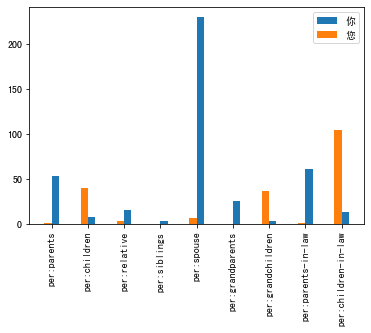

In [4]:
#graph
ni = get_scene_stats(partition1,'你')['relation']
nin = get_scene_stats(partition1,'您')['relation']

plt.rcParams['font.sans-serif'] = ['SimHei']


fig, ax = plt.subplots()

ax.bar(ni.keys(), ni.values(), width=0.2, align='edge', label='你')
ax.bar(nin.keys(), nin.values(), width=-0.2, align='edge', label='您')


ax.legend()
plt.xticks(rotation=90)


fig.show()

Conclusion: Looks like this distinction could provide reasonable signal

Next look at 只是， 不过, 但是, and 可是 

In [6]:
#Prepare data such that they can all be plotted on same axis
zhishi = get_scene_stats(partition1,'只是')['relation']
buguo = get_scene_stats(partition1,'不过')['relation']
danshi = get_scene_stats(partition1,'但是')['relation']
keshi = get_scene_stats(partition1,'可是')['relation']

all_keys = list(keshi.keys())+list(zhishi.keys())+list(buguo.keys())+ list(danshi.keys())

for item in all_keys:

    if item not in zhishi.keys():
        zhishi[item]=0
    if item not in buguo.keys():
        buguo[item]=0
    if item not in danshi.keys():
        danshi[item]=0
    if item not in keshi.keys():
        keshi[item]=0
        
keshi = collections.OrderedDict(sorted(keshi.items()))
danshi = collections.OrderedDict(sorted(danshi.items()))
buguo = collections.OrderedDict(sorted(buguo.items()))
zhishi = collections.OrderedDict(sorted(zhishi.items()))

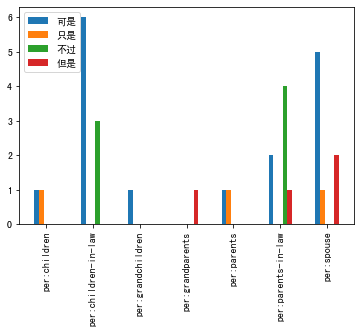

In [7]:
# set width of bar
barWidth = 0.1

X = np.arange(len(keshi))

plt.rcParams['font.sans-serif'] = ['SimHei']

fig, ax = plt.subplots()


ax.bar(X-2*barWidth, keshi.values(), width=barWidth, align='center', label='可是')
ax.bar(X-barWidth, zhishi.values(), width=barWidth, align='center', label='只是') #zhishi.keys()
ax.bar(X+barWidth, buguo.values(), width=barWidth, align='center', label='不过')
ax.bar(X+2*barWidth, danshi.values(), width=barWidth, align='center', label='但是')


ax.legend()
plt.xticks(X,keshi.keys(), rotation=90)


fig.show()

Conclusion: although the distribution may be different, the counts are too low to carry any contribution 

Everything here should really be done in percentages as well as counts

In [4]:
output = dict()
output['wc']=0
output['relation'] = dict()
output['x,y,r'] = dict()

for scene in partition1:
    for line in scene:

        for word in line['tokenized']:

            output['wc']+=1

            if line['relation_item']['r'][0] not in output['relation']:
                output['relation'][line['relation_item']['r'][0]] = 0
            output['relation'][line['relation_item']['r'][0]] +=1

            x_y_r = line['relation_item']['x'][0]+','+line['relation_item']['y']+','+line['relation_item']['r'][0]

            if x_y_r not in output['x,y,r']:
                output['x,y,r'][x_y_r] = 0
            output['x,y,r'][x_y_r] +=1
            
output_pl = output['relation']
for item in output['relation'].keys():
    output['relation'][item] = 100*output['relation'][item]/output['wc']

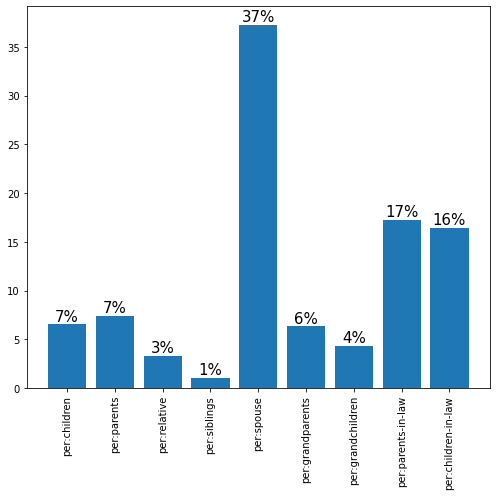

In [7]:
#graph
plt.rcParams["figure.figsize"] = [7.00, 7.00]
plt.rcParams["figure.autolayout"] = True

plt.figure()

p1 = plt.bar(np.arange(len(output_pl)), output_pl.values(),label='word count')


for rect1 in p1:
    height = rect1.get_height()
    plt.annotate( "{}%".format(round(height),1),(rect1.get_x() + rect1.get_width()/2, height+.05),ha="center",va="bottom",fontsize=15)


plt.xticks(np.arange(len(output_pl)),output_pl.keys(),rotation=90)
plt.show()

Analysis: make a correlation matrix among the 32 relations. Surely per:parent and per:child must occur together frequently

In [5]:
with open('rid_to_rel.pickle','rb') as infile:
    rid_to_rel = pickle.load(infile)

with open('rel_to_rid.pickle','rb') as infile:
    rel_to_rid = pickle.load(infile)

In [6]:
with open('../CRECIL/Final_Data/train.json','rb') as infile:
    train_df = json.loads(infile.read())

In [7]:
#create empty data frame
zero_data = np.zeros(shape=(len(train_df),len(rid_to_rel)))
gt_df = pd.DataFrame(zero_data, columns=rid_to_rel.values())

for i in range(0,len(train_df)):
    for rel_item in train_df[i][1]:
        for j in rel_item['rid']:
            gt_df.iat[i,j] = 1
            
corr_matrix = gt_df.corr()

In [5]:
corr_matrix

per:alternate_name  per:children  per:parents  \
per:alternate_name                 1.000000      0.117070     0.117070   
per:children                       0.117070      1.000000     1.000000   
per:parents                        0.117070      1.000000     1.000000   
per:acquaintance                   0.055997     -0.006048    -0.006048   
per:client                         0.080460     -0.033970    -0.033970   
per:colleague                      0.085296     -0.037705    -0.037705   
per:ex-girlfriend                  0.069229     -0.128090    -0.128090   
per:girlfriend                     0.078680     -0.150463    -0.150463   
per:dates                          0.063102     -0.115819    -0.115819   
per:ex-boyfriend                   0.069229     -0.128090    -0.128090   
per:boyfriend                      0.078680     -0.150463    -0.150463   
per:friends                        0.149174     -0.027609    -0.027609   
per:nickname                       0.022688     -0.033879    -0.033879   
per:neighbor                       0.118955     -0.156351    -0.156351   
per:nurse                          0.000293      0.061686     0.061686   
per:parents-in-law                 0.097436      0.571590     0.571590   
per:children-in-law                0.097436      0.571590     0.571590   
per:positive impression            0.099860      0.046968     0.046968   
per:classmate                      0.042768     -0.021674    -0.021674   
per:negative impression            0.112791      0.097344     0.097344   
per:subordinate                    0.041692      0.032876     0.032876   
per:boss                           0.041692      0.032876     0.032876   
per:siblings                       0.069274      0.268160     0.268160   
per:spouse                         0.108441      0.516230     0.516230   
per:grandparents                   0.092696      0.402224     0.402224   
per:grandchildren                  0.092696      0.402224     0.402224   
per:teacher                        0.048484     -0.020470    -0.020470   
per:student                        0.048484     -0.020470    -0.020470   
per:roommate                       0.016026      0.027564     0.027564   
per:relative                       0.095654      0.271393     0.271393   
per:siblings-in-law                0.042669      0.034214     0.034214   
unanswerable                       0.090971      0.099455     0.099455   

                         per:acquaintance  per:client  per:colleague  \
per:alternate_name               0.055997    0.080460       0.085296   
per:children                    -0.006048   -0.033970      -0.037705   
per:parents                     -0.006048   -0.033970      -0.037705   
per:acquaintance                 1.000000   -0.043498      -0.021592   
per:client                      -0.043498    1.000000       0.099027   
per:colleague                   -0.021592    0.099027       1.000000   
per:ex-girlfriend               -0.022164   -0.045087      -0.048390   
per:girlfriend                  -0.013124   -0.051243      -0.034804   
per:dates                        0.058844   -0.058975       0.043607   
per:ex-boyfriend                -0.022164   -0.045087      -0.048390   
per:boyfriend                   -0.013124   -0.051243      -0.034804   
per:friends                      0.343989   -0.048954       0.341840   
per:nickname                    -0.027271   -0.014776      -0.026161   
per:neighbor                    -0.080485    0.095753       0.402099   
per:nurse                       -0.098869   -0.027491      -0.167636   
per:parents-in-law               0.023380   -0.060897       0.023424   
per:children-in-law              0.023380   -0.060897       0.023424   
per:positive impression          0.056086   -0.028755      -0.069801   
per:classmate                   -0.068701   -0.062059      -0.062672   
per:negative impression          0.083241    0.057678       0.054316   
per:subordinate                 -0.082080   -0.034529      -0.107662  

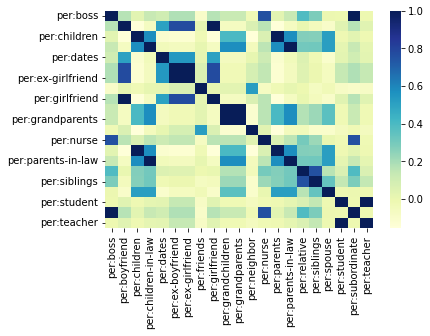

In [6]:
#code for heatmap from https://datascience.stackexchange.com/questions/82226/how-to-visualise-a-large-correlation-matrix
from numpy.random      import randn
from pandas            import DataFrame
from seaborn           import heatmap
from matplotlib.pyplot import show
from itertools         import combinations

def absHighPass(df, absThresh):
    passed = set()
    for (r,c) in combinations(df.columns, 2):
        if (abs(df.loc[r,c]) >= absThresh):
            passed.add(r)
            passed.add(c)
    passed = sorted(passed)
    return df.loc[passed,passed]

labels = [chr(x) for x in range(65,91)]

heatmap(absHighPass(corr_matrix,0.5),cmap="YlGnBu")
show()

In [7]:
for (r,c) in combinations(corr_matrix.columns, 2):
    if (abs(corr_matrix.loc[r,c]) >= 0.9):
        print((r,c))
        print(corr_matrix.loc[r,c])

('per:children', 'per:parents')
1.0
('per:ex-girlfriend', 'per:ex-boyfriend')
1.0
('per:girlfriend', 'per:boyfriend')
1.0
('per:parents-in-law', 'per:children-in-law')
1.0
('per:subordinate', 'per:boss')
1.0
('per:grandparents', 'per:grandchildren')
1.0
('per:teacher', 'per:student')
1.0


Conclusion: the above pairs of relations can essentially be predicted as one each. 

Here's a show-specific variable: dialogue-size. I wonder if the rarer relation labels aren't more common only in larger group settings than smaller?

In [8]:
def get_num_speakers(transcript:list)-> int:
    """
    return number of speakers in scene
    """
    ch_set = set()
    for line in transcript:
        ch_set.add(re.findall('S.*(?=:)',line)[0])
    
    total = len(ch_set)
    return total

In [9]:
dialog_size_d = dict()
for rel in list(rel_to_rid.keys()):
    dialog_size_d[rel] = []

for i in range(0,len(train_df)):
    
    d_size = get_num_speakers(train_df[i][0])
    
    for item in train_df[i][1]:
        for rel in item['r']:
            dialog_size_d[rel].append(d_size)

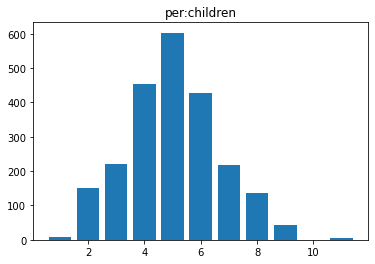

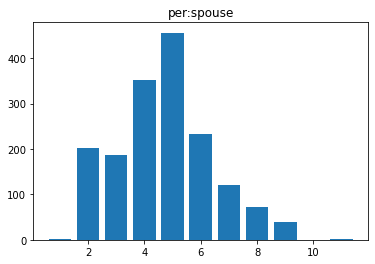

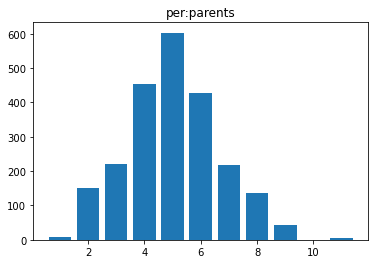

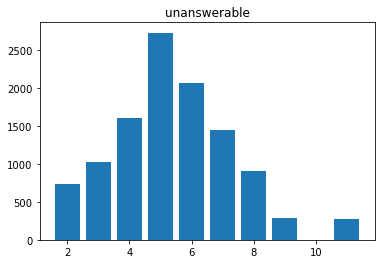

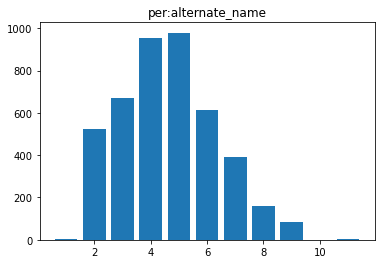

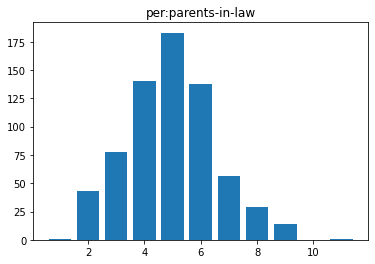

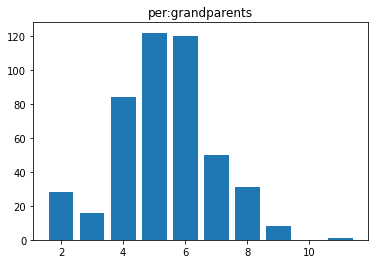

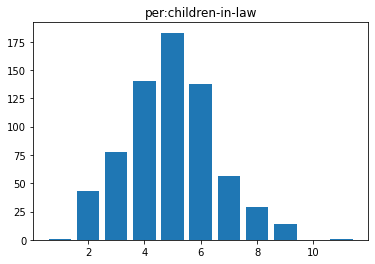

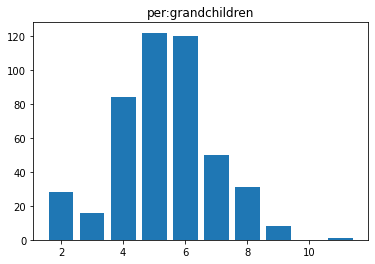

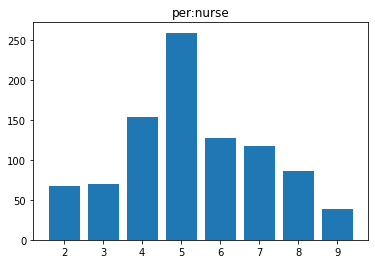

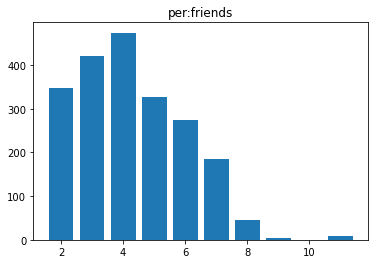

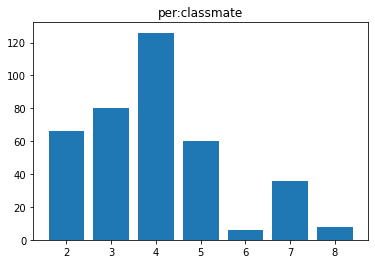

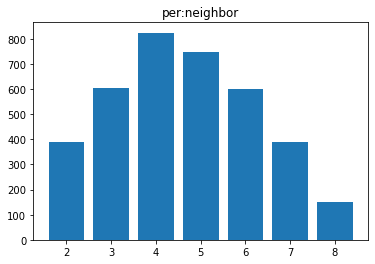

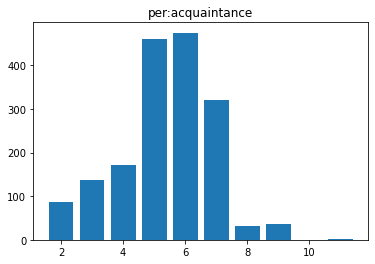

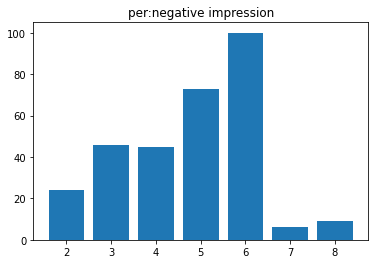

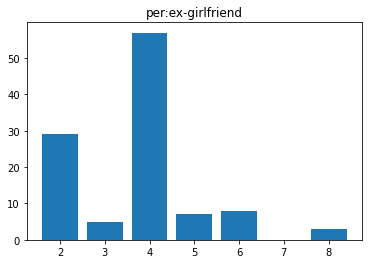

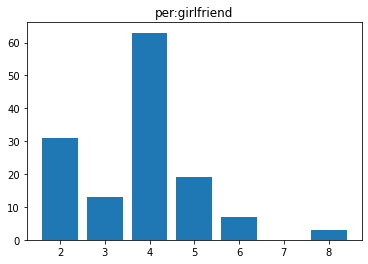

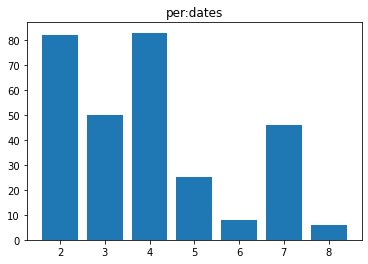

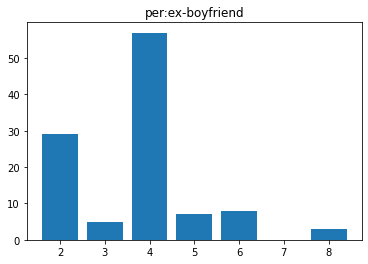

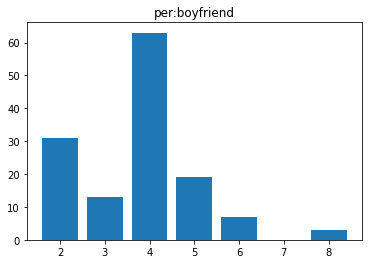

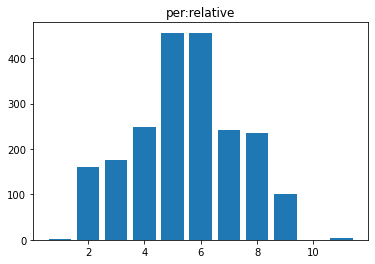

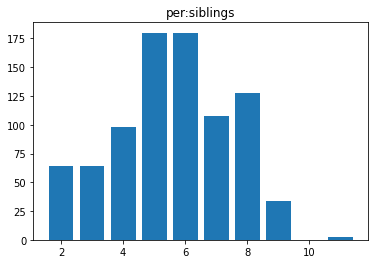

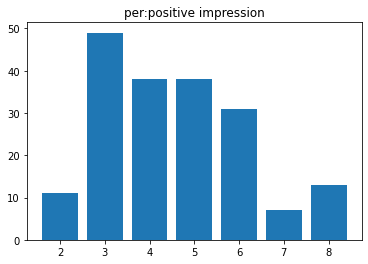

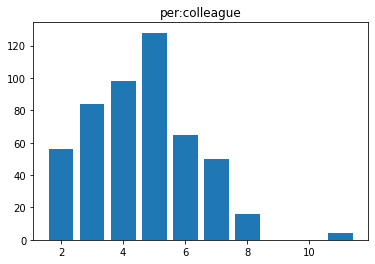

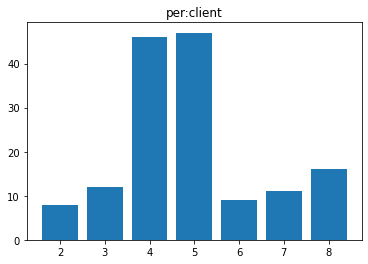

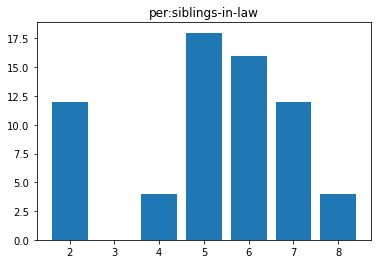

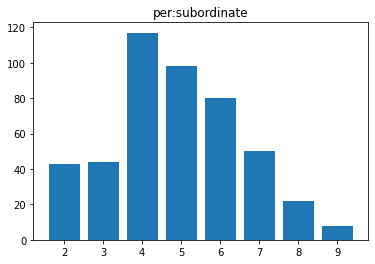

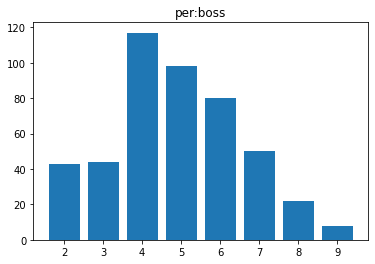

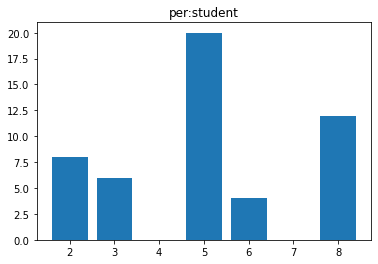

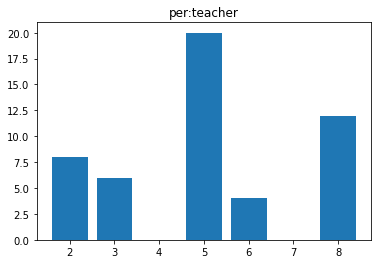

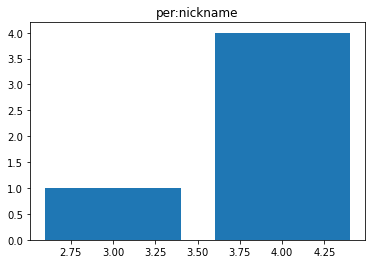

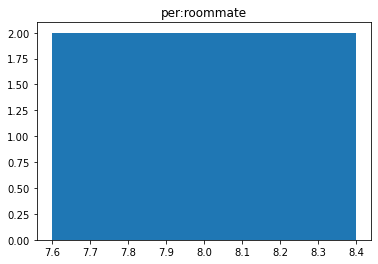

In [10]:
#iterate for each pair of relations
for pair in rel_to_rid.keys():
    
    c = collections.Counter(dialog_size_d[pair])
    c = sorted(c.items())

    plt.bar([item[0] for item in c],[item[1] for item in c])
    plt.title(pair)
    plt.show()


**Notes** 
- Most are fairly normally-distributed
- Exes (ex-girlfriend/boyfriend) mostly occur in 4s, followed by 2s
- Similar for girlfriend/boyfriend
- weird values for per:roommate, per:nickname